In this notebook, I'm going to plot the relation between training & testing dataset costs against epochs.

Notes:
* I have to reinitialise the model every time I am about to feed it data, otherwise the model is retraining.
* In retraining.ipynb, my aim was to see if I could produce an accurate mean model with an extremely small dataset. Since my aim in this notebook is different, I'll use regular-sized dataset for simplicity.

In [1]:
#importing libraries
import numpy as np
from sklearn import datasets
import torch
import torch.nn as nn
import torch.optim as optim
import torchbnn as bnn
import matplotlib.pyplot as plt
import pandas as pd


In [2]:
# transferring as much data as I can to my GPU for faster processing
#! note: this'll only work for NVIDIA GPUs
is_available = torch.cuda.is_available()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


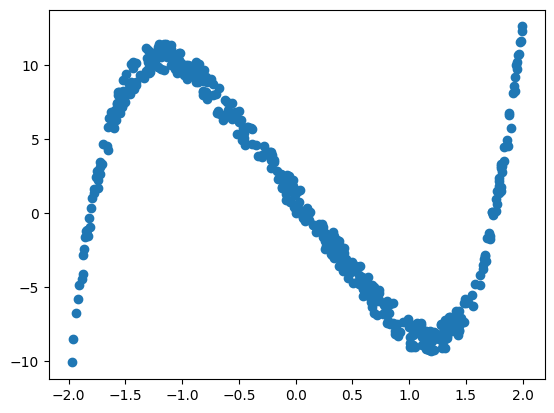

In [3]:
x_train = torch.rand(500)*4-2
y_train = x_train.pow(5) - 10 * x_train.pow(1) + 2*torch.rand(x_train.size())

plt.scatter(x_train.data.numpy(), y_train.data.numpy())
plt.show()

x_train = torch.unsqueeze(x_train, dim=1).to(device)
y_train = torch.unsqueeze(y_train, dim=1).to(device)


In [4]:
def clean_target(x):
    return x.pow(5) - 10 * x.pow(1)+1


def target(x):
    return x.pow(5) - 10 * x.pow(1) + 2*torch.rand(x.size())

In [5]:
def intialise_model(no_of_neurones: int, lr: float):
    model = nn.Sequential(
        bnn.BayesLinear(prior_mu=0, prior_sigma=0.1, in_features=1,
                        out_features=no_of_neurones),
        nn.ReLU(),
        bnn.BayesLinear(prior_mu=0, prior_sigma=0.1,
                        in_features=no_of_neurones, out_features=1),
    ).to(device)

    mse_loss = nn.MSELoss().to(device)
    kl_loss = bnn.BKLLoss(reduction='mean', last_layer_only=False).to(device)
    kl_weight = 0.01

    optimizer = optim.Adam(model.parameters(), lr=lr)

    return model, mse_loss, kl_loss, kl_weight, optimizer


In [6]:
def train_and_test(model_attributes, x_train: torch.Tensor, y_train: torch.Tensor, epochs: int):
    assert x_train.device == y_train.device == device, "Keep everything on the GPU for speed"

    model, mse_loss, kl_loss, kl_weight, optimizer = model_attributes

    for _ in range(epochs):
        predictions = model(x_train)
        mse = mse_loss(predictions, y_train)
        kl = kl_loss(model)
        cost = mse + kl_weight * kl

        optimizer.zero_grad()
        cost.backward()
        optimizer.step()

    cost_train = cost.item()
    print(f'- With {epochs} epochs, MSE : {mse.item():2.2f}, KL : {kl.item():2.2f}, Cost: {cost.item():2.2f}')


    x_test = torch.rand(1000)*4-2
    y_test = target(x_test)

    x_test = torch.unsqueeze(x_test, dim=1).to(device)
    y_test = torch.unsqueeze(y_test, dim=1).to(device)

    predictions = model(x_test)
    mse = mse_loss(predictions, y_test)
    kl = kl_loss(model)
    cost = mse + kl_weight * kl

    optimizer.zero_grad()
    cost.backward()
    optimizer.step()

    cost_test = cost.item()

    print(f'- With {epochs} epochs, MSE : {mse.item():2.2f}, KL : {kl.item():2.2f}, Cost: {cost.item():2.2f}')

    return cost_train, cost_test


Okay, everything I need is ready.

I'm testing for a range of epochs, so I'll need to call the above function quite a lot.

Mind's a little glitchy rn. Need to convert the for loop above into a function.

In [12]:
def generate_data(lr: float):
    no_of_neurones = 2000
    df = pd.DataFrame(columns=[f"cost_train_{lr}", f"cost_test_{lr}"])
    no_of_epochs = [epochs for epochs in range(100, 2501, 100)]

    for epochs in no_of_epochs:
        model_attributes = intialise_model(no_of_neurones, lr)
        cost_train, cost_test = train_and_test(model_attributes, x_train, y_train, epochs)

        df = pd.concat([df, pd.DataFrame([[epochs, cost_train, cost_test]], columns=["epochs", f"cost_train_{lr}", f"cost_test_{lr}"])], ignore_index=True)

    return df


In [13]:
# df1 = pd.DataFrame({"epochs":no_of_epochs}) #df for storing train and test costs vs epochs for a fixed lr: 0.01 in this case
# df for storing test costs against epochs for multiple lrs
# df2 = pd.DataFrame({"epochs": no_of_epochs})

lr_rates = np.array([0.1, 0.01, 0.001, 0.0001])

#generating data for df1
df1 = generate_data(lr=0.01)


- With 100 epochs, MSE : 8.16, KL : 10.43, Cost: 8.27
- With 100 epochs, MSE : 23.71, KL : 10.43, Cost: 23.81


C:\Users\joshu\AppData\Local\Temp\ipykernel_14752\1185166543.py:10: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, pd.DataFrame([[epochs, cost_train, cost_test]], columns=["epochs", f"cost_train_{lr}", f"cost_test_{lr}"])], ignore_index=True)


- With 200 epochs, MSE : 4.00, KL : 10.09, Cost: 4.10
- With 200 epochs, MSE : 30.77, KL : 10.09, Cost: 30.87
- With 300 epochs, MSE : 2.98, KL : 9.83, Cost: 3.08
- With 300 epochs, MSE : 6.21, KL : 9.83, Cost: 6.31
- With 400 epochs, MSE : 10.11, KL : 9.61, Cost: 10.20
- With 400 epochs, MSE : 2.59, KL : 9.61, Cost: 2.69
- With 500 epochs, MSE : 2.60, KL : 9.39, Cost: 2.69
- With 500 epochs, MSE : 2.99, KL : 9.39, Cost: 3.08
- With 600 epochs, MSE : 1.70, KL : 9.28, Cost: 1.79
- With 600 epochs, MSE : 1.86, KL : 9.28, Cost: 1.95
- With 700 epochs, MSE : 5.10, KL : 8.92, Cost: 5.19
- With 700 epochs, MSE : 11.21, KL : 8.91, Cost: 11.30
- With 800 epochs, MSE : 1.79, KL : 9.01, Cost: 1.88
- With 800 epochs, MSE : 6.21, KL : 9.01, Cost: 6.30
- With 900 epochs, MSE : 1.02, KL : 8.98, Cost: 1.11
- With 900 epochs, MSE : 3.07, KL : 8.98, Cost: 3.16
- With 1000 epochs, MSE : 0.89, KL : 8.89, Cost: 0.98
- With 1000 epochs, MSE : 4.38, KL : 8.88, Cost: 4.47
- With 1100 epochs, MSE : 2.62, KL :

In [9]:
#generating data for df2
df2 = pd.DataFrame({"epochs": [epochs for epochs in range(100, 1501, 100)]})
for lr in lr_rates:
    print(f"lr: {lr}")
    df2 = pd.merge(df2, generate_data(lr), on="epochs")

df2

#todo: increase the range of epochs: done
#todo: instead of storing cost values in arrays, store them in a csv file: done
#todo: convert this cell into a function: done
#todo: once you've figured out multi-dimensiionality, come back to this to find the effect of the learning rate on the cost


lr: 0.1
- With 100 epochs, MSE : 24.92, KL : 17.63, Cost: 25.10
- With 100 epochs, MSE : 20.29, KL : 17.66, Cost: 20.47


C:\Users\joshu\AppData\Local\Temp\ipykernel_14752\4257955837.py:10: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, pd.DataFrame([[epochs, cost_train, cost_test]], columns=["epochs", f"cost_train_{lr}", f"cost_test_{lr}"])], ignore_index=True)


- With 200 epochs, MSE : 12.77, KL : 20.62, Cost: 12.97
- With 200 epochs, MSE : 39.00, KL : 20.65, Cost: 39.20
- With 300 epochs, MSE : 4.60, KL : 21.62, Cost: 4.82
- With 300 epochs, MSE : 7.19, KL : 21.64, Cost: 7.41
- With 400 epochs, MSE : 4.50, KL : 21.59, Cost: 4.72
- With 400 epochs, MSE : 2.42, KL : 21.60, Cost: 2.63
- With 500 epochs, MSE : 1.79, KL : 21.46, Cost: 2.00
- With 500 epochs, MSE : 4.02, KL : 21.47, Cost: 4.24
- With 600 epochs, MSE : 0.95, KL : 23.51, Cost: 1.19
- With 600 epochs, MSE : 0.85, KL : 23.50, Cost: 1.09
- With 700 epochs, MSE : 1.10, KL : 21.81, Cost: 1.32
- With 700 epochs, MSE : 0.65, KL : 21.82, Cost: 0.87
- With 800 epochs, MSE : 3.03, KL : 25.96, Cost: 3.29
- With 800 epochs, MSE : 3.99, KL : 25.96, Cost: 4.25
- With 900 epochs, MSE : 1.75, KL : 23.35, Cost: 1.98
- With 900 epochs, MSE : 0.96, KL : 23.35, Cost: 1.19
- With 1000 epochs, MSE : 3.51, KL : 23.46, Cost: 3.74
- With 1000 epochs, MSE : 0.89, KL : 23.48, Cost: 1.12
- With 1100 epochs, MS

C:\Users\joshu\AppData\Local\Temp\ipykernel_14752\4257955837.py:10: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, pd.DataFrame([[epochs, cost_train, cost_test]], columns=["epochs", f"cost_train_{lr}", f"cost_test_{lr}"])], ignore_index=True)


- With 200 epochs, MSE : 8.93, KL : 10.28, Cost: 9.03
- With 200 epochs, MSE : 43.77, KL : 10.29, Cost: 43.87
- With 300 epochs, MSE : 5.24, KL : 10.11, Cost: 5.35
- With 300 epochs, MSE : 10.22, KL : 10.10, Cost: 10.32
- With 400 epochs, MSE : 1.29, KL : 9.41, Cost: 1.38
- With 400 epochs, MSE : 1.74, KL : 9.40, Cost: 1.83
- With 500 epochs, MSE : 15.75, KL : 9.73, Cost: 15.85
- With 500 epochs, MSE : 18.36, KL : 9.72, Cost: 18.45
- With 600 epochs, MSE : 2.04, KL : 9.22, Cost: 2.13
- With 600 epochs, MSE : 1.80, KL : 9.23, Cost: 1.89
- With 700 epochs, MSE : 2.65, KL : 9.02, Cost: 2.74
- With 700 epochs, MSE : 2.67, KL : 9.02, Cost: 2.76
- With 800 epochs, MSE : 3.50, KL : 9.21, Cost: 3.60
- With 800 epochs, MSE : 16.97, KL : 9.21, Cost: 17.06
- With 900 epochs, MSE : 2.50, KL : 8.97, Cost: 2.59
- With 900 epochs, MSE : 6.55, KL : 8.97, Cost: 6.64
- With 1000 epochs, MSE : 1.71, KL : 9.08, Cost: 1.80
- With 1000 epochs, MSE : 2.50, KL : 9.08, Cost: 2.59
- With 1100 epochs, MSE : 1.80

C:\Users\joshu\AppData\Local\Temp\ipykernel_14752\4257955837.py:10: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, pd.DataFrame([[epochs, cost_train, cost_test]], columns=["epochs", f"cost_train_{lr}", f"cost_test_{lr}"])], ignore_index=True)


- With 200 epochs, MSE : 12.97, KL : 10.48, Cost: 13.08
- With 200 epochs, MSE : 17.61, KL : 10.48, Cost: 17.71
- With 300 epochs, MSE : 16.65, KL : 10.98, Cost: 16.76
- With 300 epochs, MSE : 8.11, KL : 10.98, Cost: 8.22
- With 400 epochs, MSE : 15.13, KL : 10.86, Cost: 15.23
- With 400 epochs, MSE : 10.98, KL : 10.86, Cost: 11.09
- With 500 epochs, MSE : 19.33, KL : 10.77, Cost: 19.44
- With 500 epochs, MSE : 6.99, KL : 10.77, Cost: 7.09
- With 600 epochs, MSE : 6.11, KL : 10.74, Cost: 6.22
- With 600 epochs, MSE : 5.38, KL : 10.74, Cost: 5.48
- With 700 epochs, MSE : 4.13, KL : 10.74, Cost: 4.23
- With 700 epochs, MSE : 5.29, KL : 10.74, Cost: 5.40
- With 800 epochs, MSE : 19.50, KL : 10.50, Cost: 19.60
- With 800 epochs, MSE : 23.38, KL : 10.50, Cost: 23.48
- With 900 epochs, MSE : 12.66, KL : 10.76, Cost: 12.77
- With 900 epochs, MSE : 11.50, KL : 10.76, Cost: 11.61
- With 1000 epochs, MSE : 26.83, KL : 10.54, Cost: 26.93
- With 1000 epochs, MSE : 3.60, KL : 10.53, Cost: 3.70
- Wi

C:\Users\joshu\AppData\Local\Temp\ipykernel_14752\4257955837.py:10: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, pd.DataFrame([[epochs, cost_train, cost_test]], columns=["epochs", f"cost_train_{lr}", f"cost_test_{lr}"])], ignore_index=True)


- With 200 epochs, MSE : 37.43, KL : 10.92, Cost: 37.54
- With 200 epochs, MSE : 62.11, KL : 10.92, Cost: 62.21
- With 300 epochs, MSE : 39.79, KL : 10.90, Cost: 39.90
- With 300 epochs, MSE : 39.66, KL : 10.90, Cost: 39.77
- With 400 epochs, MSE : 27.17, KL : 11.03, Cost: 27.28
- With 400 epochs, MSE : 41.85, KL : 11.03, Cost: 41.96
- With 500 epochs, MSE : 27.42, KL : 10.94, Cost: 27.53
- With 500 epochs, MSE : 35.01, KL : 10.94, Cost: 35.12


KeyboardInterrupt: 

Okay, I've got the data as a .csv file. Now, I'm going to write a function that'll plot both the train and test costs against epochs.

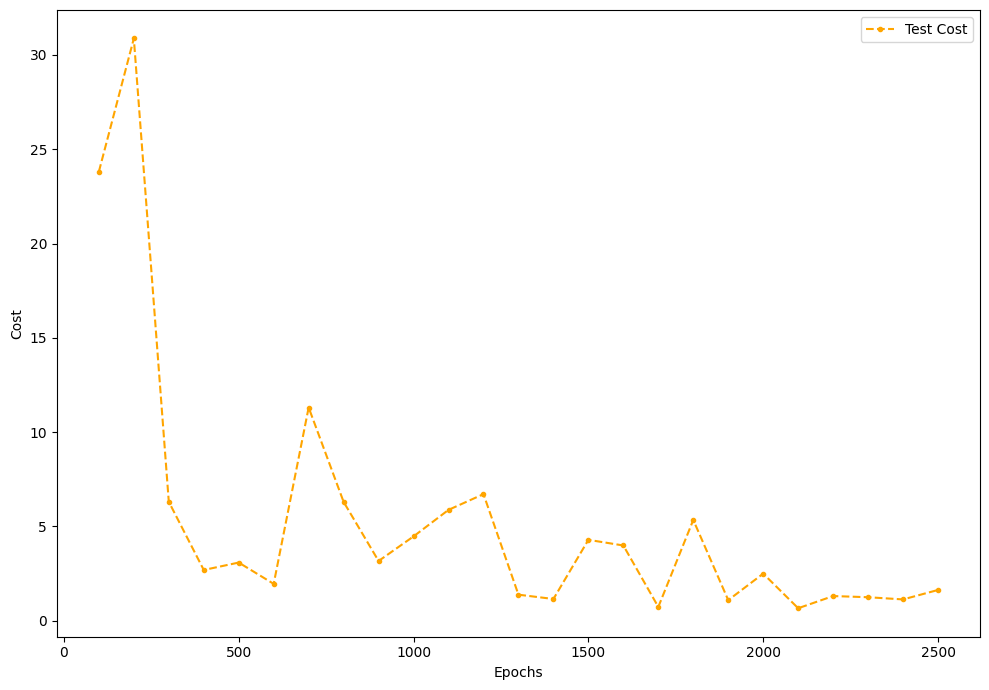

In [14]:
# Plotting the results
plt.figure(figsize=(10, 7))
# plt.plot(
#     df1["epochs"], 
#     df1["cost_train_0.01"], 
#     color='blue',
#     marker='o',
#     markersize=7,
#     linestyle='None',
#     label='Train Cost'
# )

plt.plot(
    df1["epochs"], 
    df1["cost_test_0.01"], 
    color='orange',
    marker='o',
    markersize=3,
    linestyle='--',
    label='Test Cost'
)

plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Cost')
plt.tight_layout()

plt.savefig('../../plots/cost_vs_epochs.pdf')